<h2><u>Question-2: Multi Layer Perceptron</u></h2>

<h3><b>2.1 - Multiclass Classifier</b></h3>



In [ ]:
import os
import pandas as pd
import cv2
from sklearn.preprocessing import OneHotEncoder
import gc
import cupy as cp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/smai_a2/Symbols.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/v2-125468.png    
  inflating: images/v2-125509.png    
  inflating: images/v2-125634.png    
  inflating: images/v2-12571.png     
  inflating: images/v2-125871.png    
  inflating: images/v2-125995.png    
  inflating: images/v2-126125.png    
  inflating: images/v2-126514.png    
  inflating: images/v2-126555.png    
  inflating: images/v2-126757.png    
  inflating: images/v2-126888.png    
  inflating: images/v2-126935.png    
  inflating: images/v2-127283.png    
  inflating: images/v2-127479.png    
  inflating: images/v2-127588.png    
  inflating: images/v2-127767.png    
  inflating: images/v2-127808.png    
  inflating: images/v2-127844.png    
  inflating: images/v2-128014.png    
  inflating: images/v2-128053.png    
  inflating: images/v2-128185.png    
  inflating: images/v2-128314.png    
  inflating: images/v2-128561.png    
  inflating: images/v2-128683.png    
  inflating: images/v2-128822.png    

In [ ]:
# processing data
symbols = pd.read_csv("/content/drive/MyDrive/smai_a2/symbols.csv")
unique_ids = sorted(symbols['symbol_id'].unique())
id_to_index = {symbol_id: idx for idx, symbol_id in enumerate(unique_ids)}
index_to_id = {idx: symbol_id for idx, symbol_id in enumerate(unique_ids)}
print(len(unique_ids))

def fold_data(fold):
    train_csv = os.path.join(fold, "train.csv")
    test_csv = os.path.join(fold, "test.csv")

    train_data = pd.read_csv(train_csv)
    test_data = pd.read_csv(test_csv)

    return train_data, test_data

def preprocess_data(data, fold):
    x = []
    y = []
    encoder = OneHotEncoder(sparse_output=False)

    for _, row in data.iterrows():
        img_path = os.path.join(fold, str(row["path"]))
        # print(img_path)
        symbol_id = row["symbol_id"]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.flatten() / 255.0

        x.append(img)
        y.append(id_to_index[symbol_id])

    x = cp.array(x)
    y = cp.array(y).reshape(-1, 1)
    # print(x.shape)

    y = encoder.fit_transform(y)
    return x, y

def create_batches(x, y, batch_size=32):
    num_samples = x.shape[0]
    indices = cp.random.permutation(num_samples)
    x_shuffled = x[indices]
    y_shuffled = y[indices]

    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        yield x_shuffled[start:end], y_shuffled[start:end]

369


In [ ]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, activation="tanh", optimizer="sgd"):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1

        self.activation_name = activation
        self.activation_fn, self.activation_grad = self.get_activation(activation)

        self.weights = []
        self.biases = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, self.num_layers + 1):
            self.weights.append(cp.random.randn(sizes[i], sizes[i-1]) * cp.sqrt(2 / sizes[i-1]))
            self.biases.append(cp.zeros((sizes[i], 1)))

        self.optimizer = optimizer

    def get_activation(self, name):
        if name == "tanh":
            return cp.tanh, lambda Z: 1 - cp.tanh(Z) ** 2
        elif name == "relu":
            return lambda Z: cp.maximum(0, Z), lambda Z: (Z > 0).astype(float)
        elif name == "sigmoid":
            def sigmoid(Z): return 1 / (1 + cp.exp(-Z))
            return sigmoid, lambda Z: sigmoid(Z) * (1 - sigmoid(Z))

    def softmax(self, x):
        x -= cp.max(x, axis=0, keepdims=True)  # Stability fix
        exp_x = cp.exp(x)
        return exp_x / cp.sum(exp_x, axis=0, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_true.shape[1]
        return -cp.sum(y_true * cp.log(y_pred + 1e-9)) / m # to prevent log0

    def forward(self, x):
        self.a = [x]
        self.z = []

        for i in range(self.num_layers - 1):
            Z = cp.dot(self.weights[i], self.a[i]) + self.biases[i]
            self.z.append(Z)
            self.a.append(self.activation_fn(Z))

        Z = cp.dot(self.weights[-1], self.a[-1]) + self.biases[-1] # last layer
        self.z.append(Z)
        A = self.softmax(Z)
        self.a.append(A)
        return A

    def backward(self, x, y):
        m = x.shape[1]
        gradients = []
        dZ = self.a[-1] - y  # Softmax derivative

        for i in range(self.num_layers - 1, -1, -1):
            # print(f"Layer {i}: dZ shape: {dZ.shape}, a[i] shape: {self.a[i].shape}")
            dW = (1 / m) * cp.dot(dZ, self.a[i].T)
            db = (1 / m) * cp.sum(dZ, axis=1, keepdims=True)
            gradients.append((dW, db))

            if i > 0:
                dA = cp.dot(self.weights[i].T, dZ)
                dZ = dA * self.activation_grad(self.z[i-1])

        return gradients[::-1]

    def update_parameters(self, gradients, lr):
        for i in range(self.num_layers):
            self.weights[i] -= lr * gradients[i][0]
            self.biases[i] -= lr * gradients[i][1]

    def train(self, x, y, lr, epochs, batch_size=32):
        n_samples = x.shape[0]
        losses = []

        for epoch in range(epochs):
            epoch_loss = 0

            if self.optimizer == "sgd":
                for i in range(n_samples):
                    idx = cp.random.randint(0, n_samples)
                    x_i = x[idx:idx+1].T
                    y_i = y[idx:idx+1].T

                    output = self.forward(x_i)
                    gradients = self.backward(x_i, y_i)
                    self.update_parameters(gradients, lr)
                    epoch_loss += self.cross_entropy_loss(output, y_i)

                epoch_loss /= n_samples

            elif self.optimizer == "bgd":
                output = self.forward(x.T)
                gradients = self.backward(x.T, y.T)
                self.update_parameters(gradients, lr)
                epoch_loss = self.cross_entropy_loss(output, y.T)

            elif self.optimizer == "mbgd":
                num_batches = int(cp.ceil(n_samples / batch_size))

                for i in range(num_batches):
                    start_idx = i * batch_size
                    end_idx = min(start_idx + batch_size, n_samples)

                    x_batch = x[start_idx:end_idx].T
                    y_batch = y[start_idx:end_idx].T

                    output = self.forward(x_batch)
                    gradients = self.backward(x_batch, y_batch)
                    self.update_parameters(gradients, lr)
                    epoch_loss += self.cross_entropy_loss(output, y_batch) * (end_idx - start_idx)

                epoch_loss /= n_samples


            losses.append(epoch_loss)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}")

        return losses

In [ ]:
lr = 0.01
epoch = 20
batch_size = 32

activation = ["relu", "tanh", "sigmoid"]
optimizer = ["sgd"]
fold_paths = ["/kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-1", "/kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-2", "/kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-3", "/kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-4", "/kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-5", "/kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-6",  "/kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-7",  "/kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-8",  "/kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-9",  "/kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-10"]

for op in optimizer:
  for gd in activation:
        fold_losses = []
        fold_accuracies = []

        for fold in fold_paths:
          train_data, test_data = fold_data(fold)
          x_train, y_train = preprocess_data(train_data, fold)
          x_train = cp.asarray(x_train)  # Convert to CuPy array
          y_train = cp.asarray(y_train)
          print(x_train.shape)
          print(y_train.shape)

          x_train_mean = cp.mean(x_train)
          x_train_std = cp.std(x_train)
          x_train = (x_train - x_train_mean) / x_train_std

          x_test, y_test = preprocess_data(test_data, fold)
          x_test = cp.asarray(x_test)
          y_test = cp.asarray(y_test)
          x_test = (x_test - x_train_mean) / x_train_std

          n_samples = x_train.shape[0]

          mlp = MLP(input_size=x_train.shape[1], hidden_sizes=[128,64], output_size=y_train.shape[1], activation=gd, optimizer=op)

          loss = mlp.train(x_train, y_train, lr, epoch, batch_size=batch_size)

          y_pred = mlp.forward(x_test.T)
          # print(test.shape)
          # print(y_pred.T)
          # print(y_test.T)

          # print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
          y_pred = cp.argmax(y_pred, axis=0)
          y_test = cp.argmax(y_test, axis=1)

          accuracy = cp.mean(y_pred == y_test)
          print(f"Fold {fold} - Accuracy: {accuracy}")

          fold_losses.append(loss)
          fold_accuracies.append(accuracy)

          del x_train, y_train, x_test, y_test, mlp
          gc.collect()

        accuracy = cp.mean(cp.asarray(fold_accuracies)).get()
        print(f"Activation: {gd}, Optimizer: {op}, Average Accuracy: {accuracy:.4f}\n")


(151241, 1024)
(151241, 369)
Epoch 10/20 - Loss: 6.642222368536655
Epoch 20/20 - Loss: 6.458230540624375
Fold /kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-1 - Accuracy: 0.006414783427495292
(151288, 1024)
(151288, 369)
Epoch 10/20 - Loss: 6.761361335840179
Epoch 20/20 - Loss: 6.546744320855606
Fold /kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-2 - Accuracy: 0.0037769253467099437
(151320, 1024)
(151320, 369)
Epoch 10/20 - Loss: 6.698980792275042
Epoch 20/20 - Loss: 6.498840009085549
Fold /kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-3 - Accuracy: 0.0036658191923372553
(151358, 1024)
(151358, 369)
Epoch 10/20 - Loss: 6.681277417222925
Epoch 20/20 - Loss: 6.483435198316394
Fold /kaggle/input/d/sreejaguduri/smai-a2/Symbols/classification-task/fold-4 - Accuracy: 0.002725925925925926
(151395, 1024)
(151395, 369)
Epoch 10/20 - Loss: 6.739434174934453
Epoch 20/20 - Loss: 6.517094592434268
Fold /kaggle/input/d/sreejagudur

<h4><u>Report</u></h4>

1. The mean accuracy represents the average performance of the MLP across the 10 folds. A higher mean suggests that the model predicts correctly most of the time. The standard deviation measures the spread of the model's accuracy. A low SD means that the model’s performance is consistent across different folds.

2. A lower SD would give us confidence in the model's ability to generalise because it indicates that the model is performing consistently across all the 10 folds. This means that even when it sees new data - its performance remains relatively the same - meaning it generalises really well.

3. I would choose the model with lower standard deviation, because this means that the model is more reliable - even though it does have a lower mean accuracy. With the other model with a higher standard deviation, though it does have a higher accuracy - we could not be sure that the model will always predict this reliably, given its high SD.  


<h3><b>2.2 - MLP Regressor for Price Prediction in Bangalore</b></h3>

In [ ]:
import os
import pandas as pd
import cv2
from sklearn.preprocessing import OneHotEncoder
import gc
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/MyDrive/smai_a2/Bengaluru_House_Data.csv"
df = pd.read_csv(file_path)

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


(None,
               area_type   availability                  location       size  \
 0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
 1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
 2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
 3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
 4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   
 
    society total_sqft  bath  balcony   price  
 0  Coomee        1056   2.0      1.0   39.07  
 1  Theanmp       2600   5.0      3.0  120.00  
 2      NaN       1440   2.0      3.0   62.00  
 3  Soiewre       1521   3.0      1.0   95.00  
 4      NaN       1200   2.0      1.0   51.00  )

In [ ]:
null_counts = df.isnull().sum()
print(null_counts)

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64


In [ ]:
df.drop(columns=['society'], inplace=True)
df['location'] = df['location'].fillna('Unknown')

df['size'] = df['size'].str.extract(r'(\d+)').astype(float) # get only the integers from the columns
df['size'] =  df['size'].fillna(df['size'].median())

df['bath'] = df['bath'].fillna(df['bath'].median())
df['balcony'] = df['balcony'].fillna(df['balcony'].median())

unique = df['total_sqft'].unique()
print(unique)
print(df['size'])

['1056' '2600' '1440' ... '1133 - 1384' '774' '4689']
0        2.0
1        4.0
2        3.0
3        3.0
4        2.0
        ... 
13315    5.0
13316    4.0
13317    2.0
13318    4.0
13319    1.0
Name: size, Length: 13320, dtype: float64


In [ ]:
for i in range(len(df['total_sqft'])):
    sqft = str(df.loc[i, 'total_sqft'])

    if '-' in sqft:
        sqft_range = list(map(float, sqft.split('-')))
        df.loc[i, 'total_sqft'] = np.mean(sqft_range)
    elif 'Sq. Meter' in sqft or 'sqm' in sqft.lower():
        value = float(''.join(filter(str.isdigit, sqft)))
        df.loc[i, 'total_sqft'] = value * 10.764
    elif 'perch' in sqft.lower():
        value = float(''.join(filter(str.isdigit, sqft)))
        df.loc[i, 'total_sqft'] = value * 272.25
    elif 'Sq. Yards' in sqft:
        value = float(''.join(filter(str.isdigit, sqft)))
        df.loc[i, 'total_sqft'] = value * 9.0
    elif 'Acres' in sqft:
        value = float(''.join(filter(str.isdigit, sqft)))
        df.loc[i, 'total_sqft'] = value * 43560
    elif 'Cents' in sqft:
        value = float(''.join(filter(str.isdigit, sqft)))
        df.loc[i, 'total_sqft'] = value * 435.56
    elif 'Guntha' in sqft:
        value = float(''.join(filter(str.isdigit, sqft)))
        df.loc[i, 'total_sqft'] = value * 1089
    elif 'Grounds' in sqft:
        value = float(''.join(filter(str.isdigit, sqft)))
        df.loc[i, 'total_sqft'] = value * 2400
    else:
        df.loc[i, 'total_sqft'] = float(sqft)

df['total_sqft'] = df['total_sqft'].astype(float)

In [ ]:
df.describe()

size    total_sqft          bath       balcony         price
count  13320.000000  1.332000e+04  13320.000000  13320.000000  13320.000000
mean       2.803979  5.228297e+03      2.688814      1.603378    112.565627
std        1.294214  2.262046e+05      1.338754      0.803067    148.971674
min        1.000000  1.000000e+00      1.000000      0.000000      8.000000
25%        2.000000  1.100000e+03      2.000000      1.000000     50.000000
50%        3.000000  1.278000e+03      2.000000      2.000000     72.000000
75%        3.000000  1.683250e+03      3.000000      2.000000    120.000000
max       43.000000  2.313036e+07     40.000000      3.000000   3600.000000

In [ ]:
for i in range(len(df['availability'])):
    value = str(df.loc[i, 'availability'])
    if value in ["Ready To Move", "Immediate Possession"]:
        df.loc[i, 'availability'] = value
    else:
        match = re.search(r'[A-Za-z]+', value)
        if match:
            df.loc[i, 'availability'] = match.group(0)

unique = df['availability'].unique()
print(unique)

['Dec' 'Ready To Move' 'May' 'Feb' 'Nov' 'Oct' 'Sep' 'Mar' 'Apr' 'Aug'
 'Jun' 'Jan' 'Jul' 'Immediate Possession']


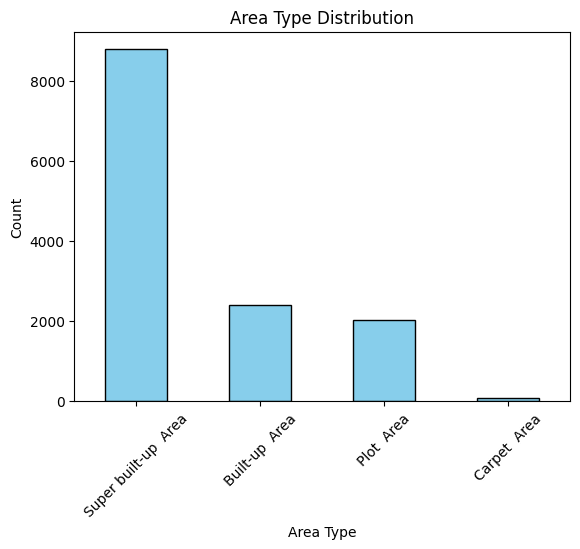

In [ ]:
plt.figure()
df['area_type'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Area Type Distribution')
plt.xlabel('Area Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

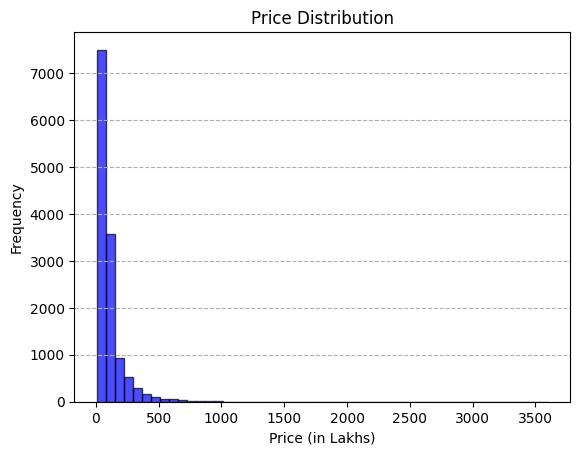

In [ ]:
plt.figure()
plt.hist(df['price'], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Price (in Lakhs)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
unique = df['location'].unique()
print(len(unique))

df = pd.get_dummies(df, columns=['area_type'])
location_freq = df['location'].value_counts()
df['location'] = df['location'].map(location_freq)
avail_freq = df['availability'].value_counts()
df['availability'] = df['availability'].map(avail_freq)

df.head()

1306


availability  location  size  total_sqft  bath  balcony   price  \
0           728       132   2.0      1056.0   2.0      1.0   39.07   
1         10581        17   4.0      2600.0   5.0      3.0  120.00   
2         10581       186   3.0      1440.0   2.0      3.0   62.00   
3         10581        23   3.0      1521.0   3.0      1.0   95.00   
4         10581        66   2.0      1200.0   2.0      1.0   51.00   

   area_type_Built-up  Area  area_type_Carpet  Area  area_type_Plot  Area  \
0                     False                   False                 False   
1                     False                   False                  True   
2                      True                   False                 False   
3                     False                   False                 False   
4                     False                   False                 False   

   area_type_Super built-up  Area  
0                            True  
1                           False  
2                           False  
3                            True  
4                            True

In [ ]:
df.columns = df.columns.str.replace(' ', '_', regex=True)
print(df.columns)
null_counts = df.isnull().sum()
print(null_counts)

Index(['availability', 'location', 'size', 'total_sqft', 'bath', 'balcony',
       'price', 'area_type_Built-up__Area', 'area_type_Carpet__Area',
       'area_type_Plot__Area', 'area_type_Super_built-up__Area'],
      dtype='object')
availability                      0
location                          0
size                              0
total_sqft                        0
bath                              0
balcony                           0
price                             0
area_type_Built-up__Area          0
area_type_Carpet__Area            0
area_type_Plot__Area              0
area_type_Super_built-up__Area    0
dtype: int64


In [ ]:
x = df[['availability', 'location', 'size', 'total_sqft', 'bath', 'balcony','area_type_Built-up__Area', 'area_type_Carpet__Area', 'area_type_Plot__Area', 'area_type_Super_built-up__Area']]
y = df['price']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=20)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=20)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(7992, 10)
(2664, 10)
(2664, 10)
(7992, 1)
(2664, 1)
(2664, 1)


In [ ]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, activation="tanh", optimizer="sgd"):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1

        self.activation_name = activation
        self.activation_fn, self.activation_grad = self.get_activation(activation)

        self.weights = []
        self.biases = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, self.num_layers + 1):
            self.weights.append(np.random.randn(sizes[i], sizes[i-1]) * np.sqrt(2 / sizes[i-1]))
            self.biases.append(np.zeros((sizes[i], 1)))

        self.optimizer = optimizer

    def get_activation(self, name):
        if name == "tanh":
            return np.tanh, lambda Z: 1 - np.tanh(Z) ** 2
        elif name == "relu":
            return lambda Z: np.maximum(0, Z), lambda Z: (Z > 0).astype(float)
        elif name == "sigmoid":
            def sigmoid(Z): return 1 / (1 + np.exp(-Z))
            return sigmoid, lambda Z: sigmoid(Z) * (1 - sigmoid(Z))

    def softmax(self, x):
        x -= np.max(x, axis=0, keepdims=True)  # Stability fix
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=0, keepdims=True)

    def mean_squared_error(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

    def forward(self, x):
        self.a = [x]
        self.z = []

        for i in range(self.num_layers - 1):
            Z = np.dot(self.weights[i], self.a[i]) + self.biases[i]
            self.z.append(Z)
            self.a.append(self.activation_fn(Z))

        Z = np.dot(self.weights[-1], self.a[-1]) + self.biases[-1] # last layer
        self.z.append(Z)
        self.a.append(Z)
        return Z

    def backward(self, x, y):
        m = x.shape[1]
        gradients = []
        dZ = self.a[-1] - y  # Softmax derivative

        for i in range(self.num_layers - 1, -1, -1):
            # print(f"Layer {i}: dZ shape: {dZ.shape}, a[i] shape: {self.a[i].shape}")
            dW = (1 / m) * np.dot(dZ, self.a[i].T)
            db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            gradients.append((dW, db))

            if i > 0:
                dA = np.dot(self.weights[i].T, dZ)
                dZ = dA * self.activation_grad(self.z[i-1])

        return gradients[::-1]

    def clip_gradients(self, gradients, clip_value=1.0):
        return [(np.clip(dW, -clip_value, clip_value), np.clip(db, -clip_value, clip_value)) for dW, db in gradients]

    def update_parameters(self, gradients, lr):
        gradients = self.clip_gradients(gradients)
        for i in range(self.num_layers):
            self.weights[i] -= lr * gradients[i][0]
            self.biases[i] -= lr * gradients[i][1]

    def train(self, x, y, lr, epochs, batch_size=32):
        n_samples = x.shape[0]
        losses = []
        mse_values = []
        rmse_values = []
        r2_values = []

        for epoch in range(epochs):
            epoch_loss = 0

            if self.optimizer == "sgd":
                for i in range(n_samples):
                    idx = np.random.randint(0, n_samples)
                    x_i = x[idx:idx+1].T
                    y_i = y[idx:idx+1].T

                    output = self.forward(x_i)
                    gradients = self.backward(x_i, y_i)
                    self.update_parameters(gradients, lr)
                    epoch_loss += self.mean_squared_error(output, y_i)

                epoch_loss /= n_samples

            elif self.optimizer == "bgd":
                output = self.forward(x.T)
                gradients = self.backward(x.T, y.T)
                self.update_parameters(gradients, lr)
                epoch_loss = self.mean_squared_error(output, y.T)

            elif self.optimizer == "mbgd":
                num_batches = int(np.ceil(n_samples / batch_size))

                for i in range(num_batches):
                    start_idx = i * batch_size
                    end_idx = min(start_idx + batch_size, n_samples)

                    x_batch = x[start_idx:end_idx].T
                    y_batch = y[start_idx:end_idx].T

                    output = self.forward(x_batch)
                    gradients = self.backward(x_batch, y_batch)
                    self.update_parameters(gradients, lr)
                    epoch_loss += self.mean_squared_error(output, y_batch) * (end_idx - start_idx)

                epoch_loss /= n_samples


            losses.append(epoch_loss)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}")

        return losses

def mean_squared_error(y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

def rootmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))

def r_squared(y_pred, y_true):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - cp.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)


Training with: Activation=tanh, Optimizer=sgd
Epoch 10/100 - Loss: 0.7993947560411898
Epoch 20/100 - Loss: 0.7863630387218837
Epoch 30/100 - Loss: 0.7099242548621768
Epoch 40/100 - Loss: 0.742603974198445
Epoch 50/100 - Loss: 0.7411558996364728
Epoch 60/100 - Loss: 0.6633012098568154
Epoch 70/100 - Loss: 0.7155926580408508
Epoch 80/100 - Loss: 0.575016172984303
Epoch 90/100 - Loss: 0.828927226748076
Epoch 100/100 - Loss: 0.7942098572061084
[[ 0.64073368  0.65733851 -0.46476314 ... -0.49959681 -0.4537103
   0.65343459]]
[[ 0.40951616  0.97331206 -0.51369963 ...  1.3256845  -0.25999147
  -0.08380525]]
Results: MSE=1.0198, RMSE=1.0099, R²=0.1979

Training with: Activation=tanh, Optimizer=bgd
Epoch 10/100 - Loss: 0.8856251180771588
Epoch 20/100 - Loss: 0.808406202371444
Epoch 30/100 - Loss: 0.7944031159766921
Epoch 40/100 - Loss: 0.787155271868095
Epoch 50/100 - Loss: 0.7816187648329498
Epoch 60/100 - Loss: 0.7769114077292428
Epoch 70/100 - Loss: 0.7727726069936394
Epoch 80/100 - Loss: 0.

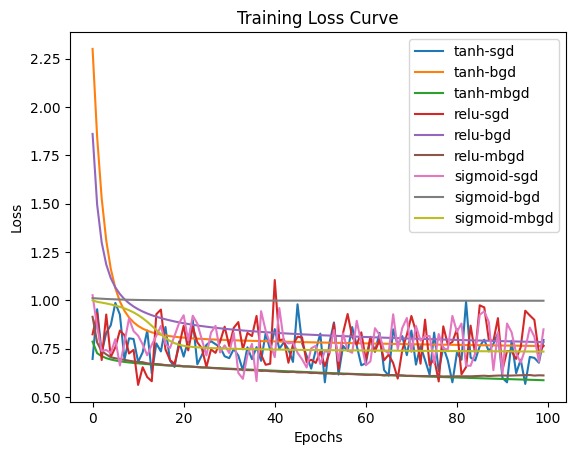

In [ ]:
lr = 0.01
epochs = 100
activation_functions = ["tanh", "relu", "sigmoid"]
optimizers = ["sgd", "bgd", "mbgd"]
results = []

for activation in activation_functions:
    for optimizer in optimizers:
        print(f"\nTraining with: Activation={activation}, Optimizer={optimizer}")
        model = MLP(input_size=x_train.shape[1], hidden_sizes=[128, 64, 32, 16], output_size=1, activation=activation, optimizer=optimizer)
        losses = model.train(x_train, y_train, lr, epochs)

        y_pred = model.forward(x_test.T)
        print(y_pred)
        print(y_test.T)
        mse = mean_squared_error(y_pred, y_test.T)
        rmse = rootmse(y_pred, y_test.T)
        r2 = r_squared(y_pred, y_test.T)

        print(f"Results: MSE={mse:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

        results.append((activation, optimizer, mse, rmse, r2))

        plt.plot(losses, label=f"{activation}-{optimizer}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [ ]:
best_model = max(results, key=lambda x: x[4])  # R²
activation, optimizer, mse, rmse, r2 = best_model

print(f"Best Model: Activation={activation}, Optimizer={optimizer}")
print(f"Results: MSE={mse:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

Best Model: Activation=relu, Optimizer=mbgd
Results: MSE=0.8978, RMSE=0.9475, R²=0.2939


<h3><b>2.3 - Multi-Label News Article Classification</b></h3>

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_file = "/content/drive/MyDrive/smai_a2/test.csv"
test_file = "/content/drive/MyDrive/smai_a2/train.csv"

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

train.head(), test.head()

(                                            document  \
 0  ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...   
 1  CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...   
 2  JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...   
 3  THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n  ...   
 4  INDONESIA SEES CPO PRICE RISING SHARPLY\n  Ind...   
 
                                  category  
 0                                   trade  
 1                                   grain  
 2                           crude,nat-gas  
 3  corn,grain,rice,rubber,sugar,tin,trade  
 4                        palm-oil,veg-oil  ,
                                             document      category
 0  BAHIA COCOA REVIEW\n  Showers continued throug...         cocoa
 1  COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...           acq
 2  N.Z. TRADING BANK DEPOSIT GROWTH RISES SLIGHTL...  money-supply
 3  NATIONAL AMUSEMENTS AGAIN UPS VIACOM &lt;VIA> ...           acq
 4  ROGERS &lt;ROG> SEES 1ST QTR NET UP SIGNI

In [ ]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  3019 non-null   object
 1   category  3019 non-null   object
dtypes: object(2)
memory usage: 47.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7769 entries, 0 to 7768
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  7769 non-null   object
 1   category  7769 non-null   object
dtypes: object(2)
memory usage: 121.5+ KB


(None, None)

In [ ]:
null_counts = train.isnull().sum()
print(null_counts)
null_counts = test.isnull().sum()
print(null_counts)

document    0
category    0
dtype: int64
document    0
category    0
dtype: int64


In [ ]:
train["category"] = train["category"].str.split(",")
test["category"] = test["category"].str.split(",")

labels = set(label for labels in train["category"] for label in labels) | set(label for labels in test["category"] for label in labels)
labels = sorted(labels)
print(len(labels))
labels[:10]

90


['acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee']

In [ ]:
mlb = MultiLabelBinarizer(classes=labels) # 90 columns for every document

train_labels = mlb.fit_transform(train["category"])
test_labels = mlb.transform(test["category"])
train_labels_df = pd.DataFrame(train_labels, columns=labels)
test_labels_df = pd.DataFrame(test_labels, columns=labels)

print(train_labels_df.shape)
train_labels_df.head()

(3019, 90)


acq  alum  barley  bop  carcass  castor-oil  cocoa  coconut  coconut-oil  \
0    0     0       0    0        0           0      0        0            0   
1    0     0       0    0        0           0      0        0            0   
2    0     0       0    0        0           0      0        0            0   
3    0     0       0    0        0           0      0        0            0   
4    0     0       0    0        0           0      0        0            0   

   coffee  ...  sun-oil  sunseed  tea  tin  trade  veg-oil  wheat  wpi  yen  \
0       0  ...        0        0    0    0      1        0      0    0    0   
1       0  ...        0        0    0    0      0        0      0    0    0   
2       0  ...        0        0    0    0      0        0      0    0    0   
3       0  ...        0        0    0    1      1        0      0    0    0   
4       0  ...        0        0    0    0      0        1      0    0    0   

   zinc  
0     0  
1     0  
2     0  
3     0  
4     0  

[5 rows x 90 columns]

In [ ]:
def tokenize(text):
    return re.findall(r'\w+', text.lower())

train_tokens = [tokenize(doc) for doc in train["document"]]
test_tokens = [tokenize(doc) for doc in test["document"]]

df_count = {}
for tokens in train_tokens:
    unique_tokens = set(tokens)
    for token in unique_tokens:
        if token in df_count:
            df_count[token] += 1
        else:
            df_count[token] = 1

docs = len(train_tokens)
sorted_tokens = sorted(df_count.items(), key=lambda x: x[1], reverse=True)
dictionary = [token for token, count in sorted_tokens[:5000]]

# idf = log((N) / (df(t))
idf = {token: np.log((docs) / (df_count[token])) for token in dictionary}

def compute_tf(doc_tokens):
    tf_dict = {}
    total_tokens = len(doc_tokens)
    for token in doc_tokens:
        tf_dict[token] = tf_dict.get(token, 0) + 1
    for token in tf_dict:
        tf_dict[token] /= total_tokens
    return tf_dict

def compute_tfidf_vector(tokens, dictionary, idf):
    tf_vector = np.zeros(len(dictionary))
    tf = compute_tf(tokens)

    for i, token in enumerate(dictionary):
        tf_vector[i] = tf.get(token, 0) * idf[token]
    return tf_vector

train_tfidf = np.array([compute_tfidf_vector(tokens, dictionary, idf) for tokens in train_tokens])
test_tfidf = np.array([compute_tfidf_vector(tokens, dictionary, idf) for tokens in test_tokens])
print("Train TF-IDF:", train_tfidf.shape)
print("Test TF-IDF:", test_tfidf.shape)

Train TF-IDF: (3019, 5000)
Test TF-IDF: (7769, 5000)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_tfidf, train_labels, test_size=0.2, random_state=42)

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)

Training set shape: (2415, 5000)
Validation set shape: (604, 5000)


In [ ]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, activation="tanh", optimizer="sgd"):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_layers = len(hidden_sizes) + 1

        self.activation_name = activation
        self.activation_fn, self.activation_grad = self.get_activation(activation)

        self.weights = []
        self.biases = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(1, self.num_layers + 1):
            self.weights.append(np.random.randn(sizes[i], sizes[i-1]) * np.sqrt(2 / sizes[i-1]))
            self.biases.append(np.zeros((sizes[i], 1)))

        self.optimizer = optimizer

    def get_activation(self, name):
        if name == "tanh":
            return np.tanh, lambda Z: 1 - np.tanh(Z) ** 2
        elif name == "relu":
            return lambda Z: np.maximum(0, Z), lambda Z: (Z > 0).astype(float)
        elif name == "sigmoid":
            def sigmoid(Z): return 1 / (1 + np.exp(-Z))
            return sigmoid, lambda Z: sigmoid(Z) * (1 - sigmoid(Z))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def binary_cross_entropy(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def forward(self, x):
        self.a = [x]
        self.z = []

        for i in range(self.num_layers - 1):
            Z = np.dot(self.weights[i], self.a[i]) + self.biases[i]
            self.z.append(Z)
            self.a.append(self.activation_fn(Z))

        Z = np.dot(self.weights[-1], self.a[-1]) + self.biases[-1]
        self.z.append(Z)
        final = self.sigmoid(Z)
        self.a.append(final)
        return final

    def backward(self, x, y):
        m = x.shape[1]
        gradients = []
        dZ = self.a[-1] - y

        for i in range(self.num_layers - 1, -1, -1):
            dW = (1 / m) * np.dot(dZ, self.a[i].T)
            db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            gradients.append((dW, db))
            if i > 0:
                dA = np.dot(self.weights[i].T, dZ)
                dZ = dA * self.activation_grad(self.z[i-1])

        return gradients[::-1]

    def clip_gradients(self, gradients, clip_value=1.0):
        return [(np.clip(dW, -clip_value, clip_value), np.clip(db, -clip_value, clip_value)) for dW, db in gradients]

    def update_parameters(self, gradients, lr):
        gradients = self.clip_gradients(gradients)
        for i in range(self.num_layers):
            self.weights[i] -= lr * gradients[i][0]
            self.biases[i] -= lr * gradients[i][1]

    def train(self, x, y, lr, epochs, batch_size=32, x_val=None, y_val=None, threshold=0.5):
        n_samples = x.shape[0]
        losses = []
        val_losses = []
        val_hamming_losses = []

        for epoch in range(epochs):
            epoch_loss = 0

            if self.optimizer == "sgd":
                for i in range(n_samples):
                    idx = np.random.randint(0, n_samples)
                    x_i = x[idx:idx+1].T
                    y_i = y[idx:idx+1].T

                    output = self.forward(x_i)
                    loss = self.binary_cross_entropy(output, y_i)
                    gradients = self.backward(x_i, y_i)
                    self.update_parameters(gradients, lr)
                    epoch_loss += loss

                epoch_loss /= n_samples

            elif self.optimizer == "bgd":
                output = self.forward(x.T)
                loss = self.binary_cross_entropy(output, y.T)
                gradients = self.backward(x.T, y.T)
                self.update_parameters(gradients, lr)
                epoch_loss = loss

            elif self.optimizer == "mbgd":
                num_batches = int(np.ceil(n_samples / batch_size))
                for i in range(num_batches):
                    start_idx = i * batch_size
                    end_idx = min(start_idx + batch_size, n_samples)
                    x_batch = x[start_idx:end_idx].T
                    y_batch = y[start_idx:end_idx].T
                    output = self.forward(x_batch)
                    loss = self.binary_cross_entropy(output, y_batch)
                    gradients = self.backward(x_batch, y_batch)
                    self.update_parameters(gradients, lr)
                    epoch_loss += loss * (end_idx - start_idx)
                epoch_loss /= n_samples

            losses.append(epoch_loss)

            if (epoch + 1) % 10 == 0:
                if x_val is not None and y_val is not None:
                    val_preds = []
                    val_preds = self.forward(x_val.T)
                    val_preds = val_preds.T
                    val_preds = np.array(val_preds)
                    val_loss = self.binary_cross_entropy(val_preds, y_val)

                    val_preds = (val_preds > threshold).astype(int)
                    val_hamming = np.mean(y_val != val_preds)

                    val_losses.append(val_loss)
                    val_hamming_losses.append(val_hamming)
                    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f} - Val Hamming: {val_hamming:.4f}")

                else:
                    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss}")

        return losses, val_losses, val_hamming_losses

def hamming_loss(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred > threshold).astype(int)
    return np.mean(y_true != y_pred_binary)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) # checking all labels


Training with: Activation=tanh, Optimizer=sgd
Epoch 10/50 - Loss: 0.0555 - Val Loss: 0.0560 - Val Hamming: 0.0140
Epoch 20/50 - Loss: 0.0501 - Val Loss: 0.0519 - Val Hamming: 0.0140
Epoch 30/50 - Loss: 0.0496 - Val Loss: 0.0514 - Val Hamming: 0.0140
Epoch 40/50 - Loss: 0.0494 - Val Loss: 0.0512 - Val Hamming: 0.0140
Epoch 50/50 - Loss: 0.0493 - Val Loss: 0.0511 - Val Hamming: 0.0140
Test Accuracy: 0.9863
Test Hamming Loss: 0.0137

Training with: Activation=tanh, Optimizer=bgd
Epoch 10/50 - Loss: 0.0548 - Val Loss: 0.0555 - Val Hamming: 0.0140
Epoch 20/50 - Loss: 0.0502 - Val Loss: 0.0519 - Val Hamming: 0.0140
Epoch 30/50 - Loss: 0.0496 - Val Loss: 0.0513 - Val Hamming: 0.0140
Epoch 40/50 - Loss: 0.0494 - Val Loss: 0.0511 - Val Hamming: 0.0140
Epoch 50/50 - Loss: 0.0493 - Val Loss: 0.0510 - Val Hamming: 0.0140
Test Accuracy: 0.9863
Test Hamming Loss: 0.0137

Training with: Activation=tanh, Optimizer=mbgd
Epoch 10/50 - Loss: 0.0545 - Val Loss: 0.0550 - Val Hamming: 0.0140
Epoch 20/50 - 

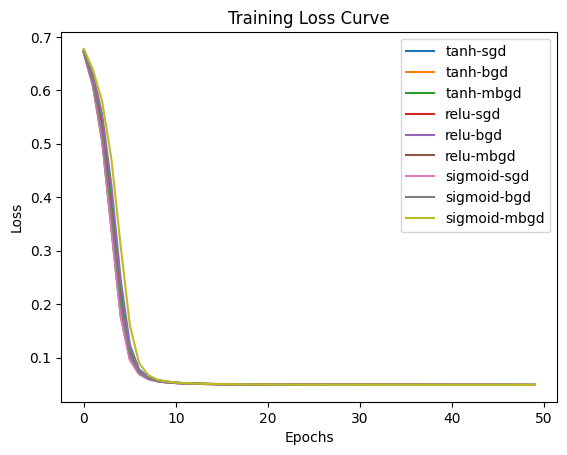

In [ ]:
lr = 0.001
epochs = 50
activation_functions = ["tanh", "relu", "sigmoid"]
optimizers = ["sgd", "bgd", "mbgd"]
results = []

for activation in activation_functions:
    for optimizer in optimizers:
        print(f"\nTraining with: Activation={activation}, Optimizer={optimizer}")
        model = MLP(input_size=5000, hidden_sizes=[128, 64], output_size=90, activation="relu", optimizer="mbgd")
        losses, val_losses, val_hamming = model.train(x_train, y_train, lr=0.001, epochs=50, batch_size=32, x_val=x_val, y_val=y_val, threshold=0.5)

        y_pred = model.forward(test_tfidf.T)
        y_pred = (y_pred > 0.5).astype(int).T
        # print(y_pred)
        # print(test_labels)
        test_acc = accuracy(test_labels, y_pred)
        test_hamming = hamming_loss(test_labels, y_pred, threshold=0.5)

        results.append((activation, optimizer, losses, val_losses, val_hamming, test_acc, test_hamming))
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test Hamming Loss: {test_hamming:.4f}")
        plt.plot(losses, label=f"{activation}-{optimizer}")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

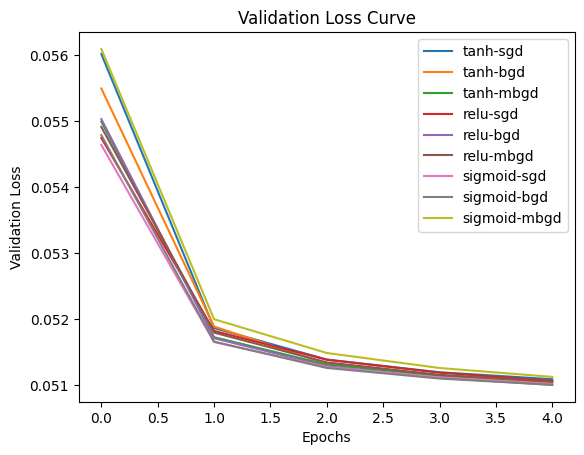

In [ ]:
plt.figure()
i = 0
for activation in activation_functions:
    for optimizer in optimizers:
        plt.plot(results[i][3], label=f"{activation}-{optimizer}")
        i+=1

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curve")
plt.legend()
plt.show()

In [ ]:
best_model = min(results, key=lambda x: x[6])
activation, optimizer, _, val1, val2, test_accuracy, test_hamming  = best_model
print(f"Best Model: Activation={activation}, Optimizer={optimizer}")
print("Final Training Loss:", _)
print("Test Accuracy:", test_accuracy)
print("Test Hamming Loss:", test_hamming)

Best Model: Activation=tanh, Optimizer=sgd
Final Training Loss: [0.6729338755643717, 0.6206916802395217, 0.5389926771239684, 0.40147865778378244, 0.23225132448710586, 0.12041951064314435, 0.07837340890661643, 0.06427081903841003, 0.05845400382054398, 0.0555166884782997, 0.05380338476353611, 0.052706318205380034, 0.05196168694809313, 0.0514352325912782, 0.051049990443684586, 0.05075964237837707, 0.05053539892299161, 0.05035891326409256, 0.05021779127879316, 0.050103293319414, 0.05000909603314148, 0.04993047220667732, 0.04986390384658678, 0.04980673220355357, 0.049757024395674324, 0.04971330385325421, 0.04967448874638941, 0.04963972160751286, 0.04960834639501299, 0.04957986679202491, 0.04955385403514107, 0.04952998865753293, 0.049507991820663316, 0.049487610584963, 0.04946863531713175, 0.04945091543300065, 0.049434391385114386, 0.049418940566461386, 0.04940446921387357, 0.04939085000657492, 0.049378005043698096, 0.049365863448797835, 0.049354369744730855, 0.04934346045916465, 0.049333081